In [402]:
# basic calculation and plotting
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import json
from typing import Tuple, Any


# astrophysics lib
import healpy as hp
from astropy import units as u
from astropy.coordinates import SkyCoord

# custom functions
import os
import sys
sys.path.append('..')
sys.path.append('../functions')
import calc_unit_conversion as uc
import calc_projection as cp
import calc_contour as cc
import calc_orientation as co
import calc_mcf as cm
from importlib import reload
reload(cp)
reload(uc)
reload(co)
reload(cc)
reload(cm)

# plotting setting
dpi = 200
plt.rcParams['figure.dpi'] = dpi
plt.rcParams['savefig.dpi'] = dpi
plt.style.use(['science','ieee'])
plt.rcParams['figure.figsize'] = 5,5


In [3]:
%config InlineBackend.figure_format = 'svg'

In [4]:
%%html
<style>
.output_svg div{
  width: 100% !important;
  height: 100% !important;
}
</style>

In [5]:
# read fit file.
# interstellar extinction from the 2MASS survey with NICER methords
# see this link for more details http://www.interstellarmedium.org/Extinction
# modify the link if required.
fit_file = './raw/fits/NICER_AJ_M1_FWHM3.0.fits'

if not os.path.isfile(fit_file): 
    # if no file.
    print('file not exist')
else: 
    fit_data = hp.read_map(fit_file)

In [530]:
class HiddenPrints:
    """
        class to disable print
        see https://www.codegrepper.com/code-examples/python/python+turn+off+printing
        
        usage:
        
        with HiddenPrints():
            print("This wont print")
    """
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


class molecular_cloud():

    def __init__(self, name, ra, dec, distance = None, size = None):
        
        self.name = name
        self.size = size
        self.distance = distance
        
        # convert units
        self.ra = uc.time_to_deg(*ra)
        self.dec = uc.dec_to_deg(*dec)
        
        # calculate the lat - lon of the cloud
        self.coor = SkyCoord(ra=self.ra*u.degree, dec=self.dec*u.degree, frame='icrs')
        self.l = self.coor.galactic.l.value
        self.b = self.coor.galactic.b.value
        
        
    def calc_all(self):
        
        # get current cloud
        self.cloud = self.get_cloud(fit_data)
        
        # calculated connected structure and minimum density
        self.connected, self.density_threshold = self.calc_connected()
        
        # convert map into xyz data
        self.x, self.y, self.z = self.to_xyz()
        
        # calculate the major - minor axis.
        self.magnitude, [self.major, self.minor] = co.calc_weighted_orientation_axis(self.x, self.y, self.z)
        
        # calculate the center of the cloud
        self.cx, self.cy = self.calc_center()

        # calculate the aspect ratio of the cloud
        self.aspect = np.sqrt(self.magnitude[0] / self.magnitude[1])        
        
        # calculate the mcf
        self.mcf_cld, self.mcf_cld_bin, self.mcf_cld_slope, \
        self.mcf_all, self.mcf_all_bin, self.mcf_all_slope = self.calc_mcf()
        
        # calculate density pdf
        self.pdf_bin, self.pdf_all, self.pdf_cld = self.calc_pdf()
        
    def get_cloud(self, fit_data) -> Any:

        sky_map = hp.gnomview(fit_data, rot=[self.l, self.b, 0],
                                 unit="",
                                 format="%.2g",
                                 xsize=self.size,
                                 flip='astro',
                                 coord='G',
                                 norm='None',
                                 return_projected_map=True,
                                 no_plot=True)
        return sky_map
    
    def to_xyz(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
            convert into xy-density data.
        """
        
        nx, ny = self.connected.shape
        
        x = np.arange(nx)
        y = np.arange(ny)
        
        x, y = np.meshgrid(x, y)
        
        x = x[self.connected > 0]
        y = y[self.connected > 0]
        z = self.connected[self.connected > 0]
        
        return x, y, z
        
    def calc_connected(self) -> Tuple[np.ndarray, float]:

        # disable pring for the search boundary function.
        with HiddenPrints():
            # calculate the mask for the connected structure.
            mask, threshold = cc.binary_search_bondory_2d(self.cloud.data, min_threshold=0, max_threshold=2)
            
            # apply for the mask
            connected = self.cloud.data.copy()
            connected[mask == 0] = np.nan
                        
            return connected, threshold
    
    def calc_center(self) -> Tuple[float, float]:
        return np.mean(self.x), np.mean(self.y)
    
    def calc_mcf(self) -> Tuple[np.ndarray, np.ndarray, float]: 
        """
            Calculate the mcf of the current cloud
        """
        # calculate the maximum intensity from the data
        max_den = np.max(fit_data)
        
        
        # TODO cloud defined
        # create bin for the mcf, common bin for all clouds.
        mcf_bin = np.linspace(0, max_den, 1000)
        # calculate mcf
        mcf_cld, mcf_cld_bin = cm.calc_mcf(self.connected.flatten(), bins = mcf_bin, threshold = 0, dx = 1)
        # calculate mcf slope
        mcf_cld_slope = cm.calc_mcf_slope_and_area(mcf_cld, mcf_cld_bin)
        
        # TODO the whole box
        # calculate mcf
        mcf_all, mcf_all_bin = cm.calc_mcf(self.cloud.data.flatten(), bins = mcf_bin, threshold = 0, dx = 1)
        # calculate mcf slope
        mcf_all_slope = cm.calc_mcf_slope_and_area(mcf_all, mcf_all_bin)
        
        return mcf_cld, mcf_cld_bin, mcf_cld_slope, mcf_all, mcf_all_bin, mcf_all_slope
        
    def calc_pdf(self) -> Tuple[np.ndarray, np.ndarray]:
        """
            Calculate the density PDF
        """
        
        pdf_bin = np.geomspace(0.001, 10, 100)
        pdf_all, pdf_bin = np.histogram(self.cloud.data.flatten(), pdf_bin)
        pdf_cld, pdf_bin = np.histogram(self.connected.flatten(), pdf_bin)
        pdf_bin = (pdf_bin[1:] + pdf_bin[:-1])/2
        
        return pdf_bin, pdf_all, pdf_cld
    
    def plot_map_quick(self) -> None:
        
        # plot density map
        plt.imshow(self.connected)
        
        # plot major and minor axis
        majx = np.array([self.cx, self.cx + self.major[0] * np.sqrt(self.magnitude[0]) ])
        majy = np.array([self.cy, self.cy + self.major[1] * np.sqrt(self.magnitude[0]) ])
        
        minx = np.array([self.cx, self.cx + self.minor[0] * np.sqrt(self.magnitude[1]) ])
        miny = np.array([self.cy, self.cy + self.minor[1] * np.sqrt(self.magnitude[1]) ])
        
        plt.plot(majx, majy)
        plt.plot(minx, miny)
        
        # other setting.
        plt.xlim(0, self.size)
        plt.ylim(0, self.size)
        plt.show()
    
    def plot_details(self, fig_path: str = None) -> None: 
        """
            Plot a graph with sky map, mcf and density pdf.
        """

        # define three plot
        fig, axs = plt.subplots(1, 3,figsize=(10,3))
        # subtitle of the whole plot
        fig.suptitle(self.name)


        # TODO first plot: sky map
        axs[0].imshow(self.cloud.data, cmap='gray', vmin = 0, vmax = 3) # sky map
        axs[0].imshow(self.connected, cmap='hot', vmin = 0, vmax = 3) # cloud defined
        axs[0].set_ylim(0, self.size) # ensure the cooridinate is not reversed.
        axs[0].set_xticks([self.size/2], [""]) # remove ticks 
        axs[0].set_yticks([self.size/2], [""]) # remove ticks 
        # Defination of the fit file.
        axs[0].set_ylabel(f"$1.5^\prime$/pix, {self.size:d}$\times${self.size:d} pix")
        # The Galactic cooridinate of the cloud.
        axs[0].set_xlabel(f"({self.l:.2f}$^\circ$, {self.b:.2f}$^\circ$) $\;\;\;$ Galactic")
        axs[0].set_title('Extinction', fontdict={'fontsize': 8})


        # TODO second plot: mcf
        axs[1].plot(self.mcf_all_bin, self.mcf_all, label='whole cube')
        axs[1].plot(self.mcf_cld_bin, self.mcf_cld, label='contour')
        # axis labels
        axs[1].set_ylim(1e-4, 1e1)
        axs[1].set_yscale('log')
        axs[1].set_xlabel("$A_V$ [mag]")
        axs[1].set_ylabel("MCF [$M_{trs}$]")
        axs[1].legend(loc='upper center', ncol=2)
        axs[1].set_title('Mass cumulative function', fontdict={'fontsize': 8})

        # TODO third plot: Density pdf.
        axs[2].step(self.pdf_bin[self.pdf_all > 0], self.pdf_all[self.pdf_all > 0], label='whole cube')
        axs[2].step(self.pdf_bin[self.pdf_cld > 0], self.pdf_cld[self.pdf_cld > 0], label='contour')
        axs[2].set_yscale('log')
        axs[2].set_xscale('log')
        axs[2].set_xlim(1e-2, 10)
        axs[2].set_ylim(0.9, 10**(np.round(np.log10(pdf_all.max()), 0) + 1))
        axs[2].set_xlabel(r'log$_{10}A_V$')
        axs[2].set_ylabel(r'N')
        axs[2].legend(loc='upper center', ncol=2)
        axs[2].set_title('Density PDF', fontdict={'fontsize': 8})


        if fig_path: 
            
            fig_full_path = os.path.join(fig_path, f"detail_{self.name.lower().replace('-', '_').replace(' ', '_')}.jpg")
            print (f"saving plot {fig_full_path} ...")
            plt.savefig(fig_full_path, dpi=600, transparent=False)
            
        plt.show()

In [500]:
# read the JSON data defined by myself.
with open('./cloud_definations.json', 'r') as data_file:
    data = json.load(data_file)

In [534]:
# storing the outputs.
clouds = {}

# name of the cloud in used.
# "Aquila", "Lupus_I", "Perseus"
cloud_names = ["Taurus", "Cr_A", "Cha_I_III", "IC5146",
               "Orion_B", "Orion_A", "Ophiuchus", "Musca",
               "Aquila", "Lupus_I", "Perseus"]
# from PLANCK
magnetic_field = np.array([74, 0, 82, 75, 57, 24, 36, 71,
                           8, 81, 64])

# initialize for all clouds.
for cloud_name in cloud_names:

    # initialize the cloud object.
    clouds[cloud_name] = molecular_cloud(**data[cloud_name])
    clouds[cloud_name].calc_all()

saving plot ../images/obs_clouds/detail_taurus.jpg ...


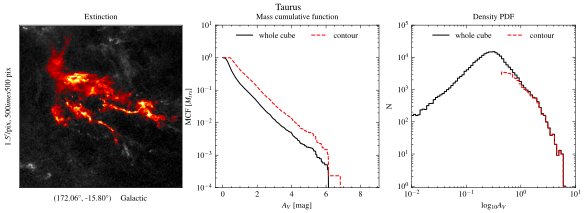

In [532]:
# TODO Plot everything of all the clouds
fig_path = '../images/obs_clouds/'

for cloud in clouds.values():
    cloud.plot_details()

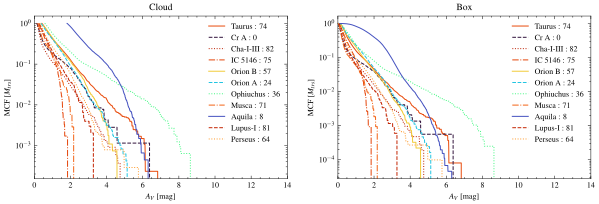

In [542]:
# TODO plot all mcf in a same figure with color scale based on the boffset.

# cmap
from matplotlib import cm as CM
cmap = CM.get_cmap('turbo')

# two plot, left: cloud <-> right: box
fig, axs = plt.subplots(1, 2, figsize = (10, 3))

for i, cloud in enumerate(clouds.values()):
    
    # TODO cloud
    x = cloud.mcf_cld_bin
    y = cloud.mcf_cld
    x = x[np.sum(y == 1)-1:]
    y = y[np.sum(y == 1)-1:]
    
    axs[0].plot(x, y, color = cmap(magnetic_field[i]/90),
                label=f"{cloud.name: <16}: {magnetic_field[i]: 2d}")
    
    # TODO box
    x = cloud.mcf_all_bin
    y = cloud.mcf_all
    x = x[np.sum(y == 1)-1:]
    y = y[np.sum(y == 1)-1:]
    
    axs[1].plot(x, y, color = cmap(magnetic_field[i]/90),
                label=f"{cloud.name: <16}: {magnetic_field[i]: 2d}")

for ax in axs:
    ax.set_xlabel("$A_V$ [mag]")
    ax.set_ylabel("MCF [$M_{trs}$]")
    ax.set_xlim(0, 14)
    ax.legend()
    ax.set_yscale('log')


axs[0].set_title('Cloud')
axs[1].set_title('Box')
plt.show()

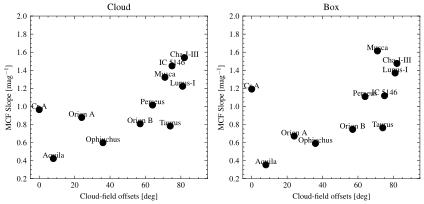

In [565]:
mcf_slope_clds = np.array([cld.mcf_cld_slope[0] for cld in clouds.values()])
mcf_slope_alls = np.array([cld.mcf_all_slope[0] for cld in clouds.values()])

mcf_slope_clds /= mcf_slope_clds.mean()
mcf_slope_alls /= mcf_slope_alls.mean()

# two plot, left: cloud <-> right: box
fig, axs = plt.subplots(1, 2, figsize = (7, 3))

axs[0].scatter(magnetic_field, mcf_slope_clds)
axs[1].scatter(magnetic_field, mcf_slope_alls)

for i, [cloud_name, cloud] in enumerate(clouds.items()):    
    axs[0].text(magnetic_field[i], mcf_slope_clds[i] + 0.01, cloud.name, ha = 'center')
    axs[1].text(magnetic_field[i], mcf_slope_alls[i] + 0.01, cloud.name, ha = 'center')


for ax in axs:
    ax.set_xlim(-5, 95)
    ax.set_ylim(0.2, 2)
    ax.set_xlabel("Cloud-field offsets [deg]")
    ax.set_ylabel("MCF Slope [mag$^{-1}$]")
    
axs[0].set_title('Cloud')
axs[1].set_title('Box')
plt.show()

In [568]:
# calculate the aspect ratio
aspects = np.array([cloud.aspect for cloud in clouds.values()])

# kernal density of the kde
kernal = gaussian_kde(aspects, 0.2)
x = np.linspace(0, 6, 200)
y = kernal(x)

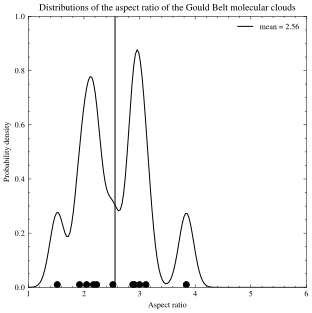

In [570]:
plt.plot(x, y)
plt.vlines(np.mean(aspects), 0, 1, label = f"mean = {np.mean(aspects):.2f}")
plt.scatter(aspects, np.zeros_like(aspects) + 0.01, )

plt.title('Distributions of the aspect ratio of the Gould Belt molecular clouds')
plt.xlabel('Aspect ratio')
plt.ylabel('Probability density')
plt.legend()
plt.ylim(0, 1)
plt.xlim(1, 6)
plt.show()